## Stable Diffusion (Text to Image)

#### I. Imports 

In [2]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.utils import name_from_base
from sagemaker.predictor import Predictor
from sagemaker import get_execution_role
from sagemaker.model import Model
from sagemaker import script_uris
from sagemaker import image_uris
from sagemaker import model_uris
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import datetime
import logging
import boto3
import json

##### Setup logging 

In [3]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

##### Log versions of dependencies 

In [4]:
logger.info(f'[Using sagemaker version: {sagemaker.__version__}]')
logger.info(f'[Using boto3 version: {sagemaker.__version__}]')

[Using sagemaker version: 2.143.0]
[Using boto3 version: 2.143.0]


#### II. Setup essentials 

__Permissions and environment variables__


To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 



In [5]:
ROLE = get_execution_role()
REGION = boto3.Session().region_name
session = sagemaker.Session()
logger.info(f'Region: {REGION}')

Region: eu-central-1


##### List all models from SageMaker JumpStart hub

In [6]:
models = list_jumpstart_models()
logger.info(f'Total number of models in SageMaker JumpStart hub = {len(models)}')

Total number of models in SageMaker JumpStart hub = 649


In [7]:
FILTER = 'task == txt2img'
txt2img_models = list_jumpstart_models(filter=FILTER)
txt2img_models

['huggingface-txt2img-22h-vintedois-diffusion-v0-1',
 'huggingface-txt2img-akikagura-mkgen-diffusion',
 'huggingface-txt2img-alxdfy-noggles-fastdb-4800',
 'huggingface-txt2img-alxdfy-noggles9000',
 'huggingface-txt2img-andite-anything-v4-0',
 'huggingface-txt2img-astraliteheart-pony-diffusion-v2',
 'huggingface-txt2img-avrik-abstract-anim-spritesheets',
 'huggingface-txt2img-aybeeceedee-knollingcase',
 'huggingface-txt2img-bingsu-my-k-anything-v3-0',
 'huggingface-txt2img-bingsu-my-korean-stable-diffusion-v1-5',
 'huggingface-txt2img-buntopsih-novgoranstefanovski',
 'huggingface-txt2img-claudfuen-photorealistic-fuen-v1',
 'huggingface-txt2img-coder119-vectorartz-diffusion',
 'huggingface-txt2img-conflictx-complex-lineart',
 'huggingface-txt2img-dallinmackay-cats-musical-diffusion',
 'huggingface-txt2img-dallinmackay-jwst-deep-space-diffusion',
 'huggingface-txt2img-dallinmackay-tron-legacy-diffusion',
 'huggingface-txt2img-dallinmackay-van-gogh-diffusion',
 'huggingface-txt2img-dgspitz

In [8]:
MODEL_ID = 'model-txt2img-stabilityai-stable-diffusion-v2-1-base'
MODEL_VERSION = '*'  # latest
SCOPE = 'inference'
INFERENCE_INSTANCE_TYPE = 'ml.p3.2xlarge'  # prefered

#### III. Retrieve inference artifacts 

In [9]:
inference_image_uri = image_uris.retrieve(region=REGION, 
                                          framework=None,
                                          model_id=MODEL_ID, 
                                          model_version=MODEL_VERSION, 
                                          image_scope=SCOPE, 
                                          instance_type=INFERENCE_INSTANCE_TYPE)
logger.info(f'Inference image URI: {inference_image_uri}')

Inference image URI: 763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04


In [10]:
inference_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                            model_version=MODEL_VERSION, 
                                            script_scope=SCOPE)
logger.info(f'Inference source URI: {inference_source_uri}')

Inference source URI: s3://jumpstart-cache-prod-eu-central-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz


In [11]:
inference_model_uri = model_uris.retrieve(model_id=MODEL_ID, 
                                          model_version=MODEL_VERSION, 
                                          model_scope=SCOPE)
logger.info(f'Inference model URI: {inference_model_uri}')

Inference model URI: s3://jumpstart-cache-prod-eu-central-1/stabilityai-infer/infer-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz


In [15]:
# To increase the maximum response size from the endpoint
env = {'MMS_MAX_RESPONSE_SIZE': '20000000'}
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
endpoint_name = f'js-cats-lab1-{current_time}'
logger.info(f'Endpoint name = {endpoint_name}')

Endpoint name = js-cats-lab1-20230403172239


In [17]:
model = Model(image_uri=inference_image_uri,
              source_dir=inference_source_uri,
              model_data=inference_model_uri,
              entry_point='inference.py',  
              role=ROLE,
              predictor_cls=Predictor,
              name=endpoint_name,
              env=env)

#### IV. Deploy Stable Diffusion model as a SageMaker endpoint

Takes around 11 to 14 mins

In [18]:
%%time

_ = model.deploy(initial_instance_count=1, 
                 instance_type=INFERENCE_INSTANCE_TYPE, 
                 predictor_cls=Predictor, 
                 endpoint_name=endpoint_name)

Creating model with name: js-cats-lab1-20230403172239
CreateModel request: {
    "ModelName": "js-cats-lab1-20230403172239",
    "ExecutionRoleArn": "arn:aws:iam::106877348565:role/service-role/AmazonSageMaker-ExecutionRole-20230120T102711",
    "PrimaryContainer": {
        "Image": "763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04",
        "Environment": {
            "MMS_MAX_RESPONSE_SIZE": "20000000",
            "SAGEMAKER_PROGRAM": "inference.py",
            "SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/code",
            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
            "SAGEMAKER_REGION": "eu-central-1"
        },
        "ModelDataUrl": "s3://sagemaker-eu-central-1-106877348565/js-cats-lab1-20230403172239/model.tar.gz"
    },
    "Tags": [
        {
            "Key": "aws-jumpstart-inference-model-uri",
            "Value": "s3://jumpstart-cache-prod-eu-central-1/stabilityai-infer/infer-model

------------!CPU times: user 5min 33s, sys: 59.6 s, total: 6min 32s
Wall time: 13min 29s


#### V. Invoke the endpoint for inference 

In [19]:
client = boto3.client('sagemaker-runtime')

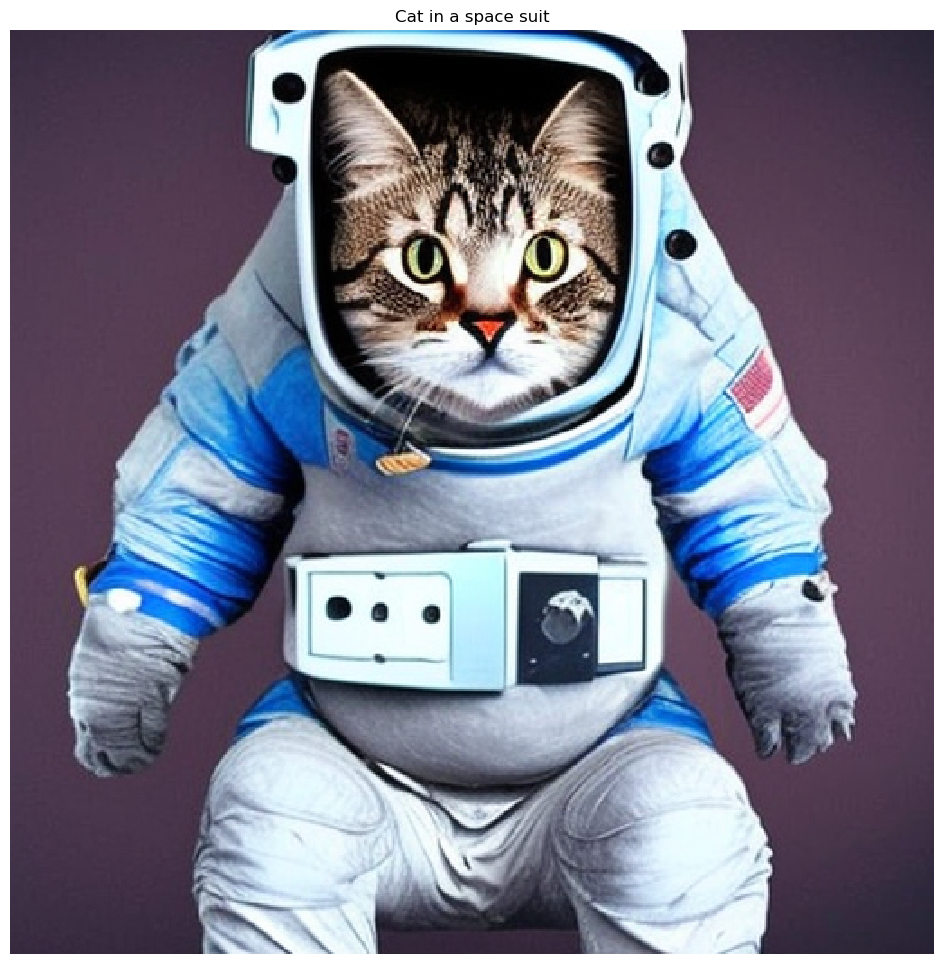

CPU times: user 874 ms, sys: 38.3 ms, total: 912 ms
Wall time: 8.42 s


In [23]:
%%time

prompt = 'Cat in a space suit'
response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                  Body=prompt, 
                                  ContentType='application/x-text')


response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()

##### Invoke the model with generation parameters

**Supported Inference parameters**

This model also supports many advanced parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: Number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: Higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer. 
* **seed**: Fix the randomized state for reproducibility. If specified, it must be an integer.

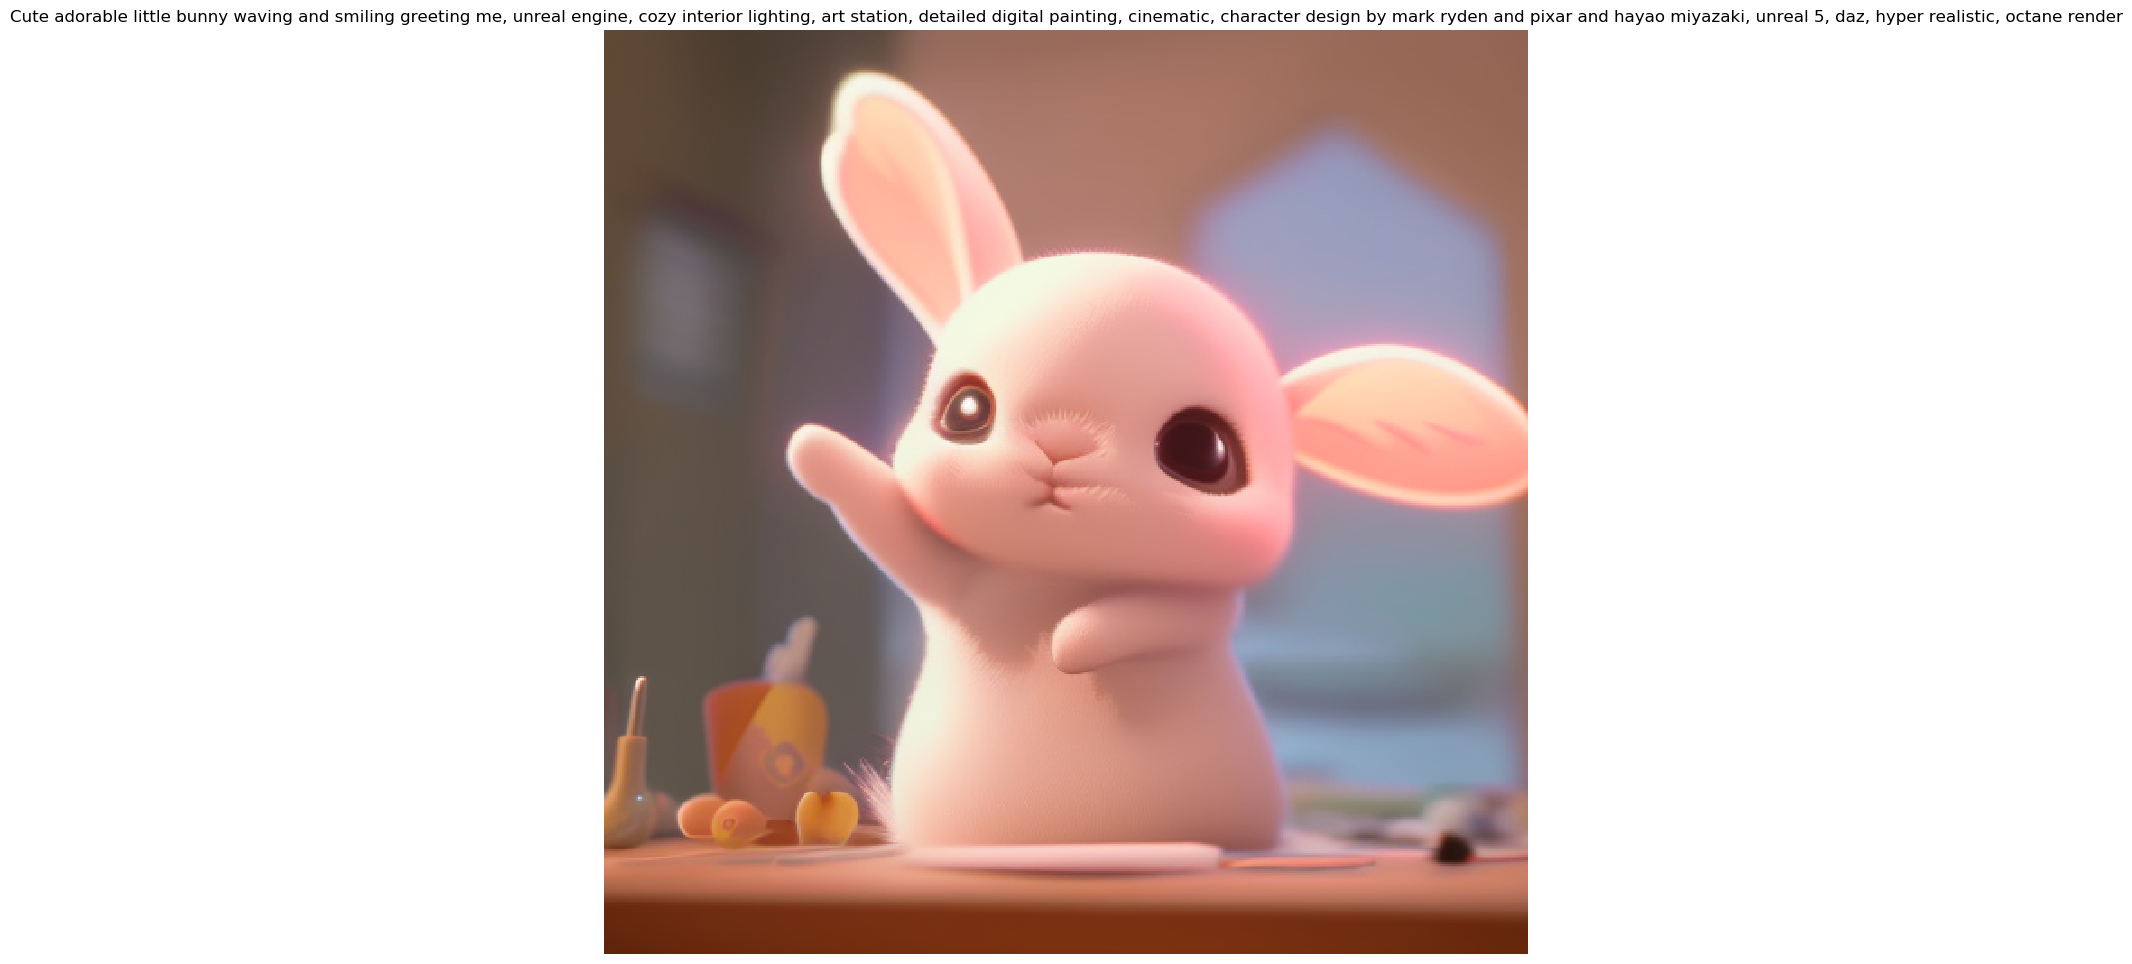

CPU times: user 1.14 s, sys: 17.5 ms, total: 1.15 s
Wall time: 9.14 s


In [52]:
%%time

prompt = (
    "a cute magical flying cat,"
    " fantasy art drawn by disney concept artists, golden colour,"
    " high quality, highly detailed, elegant, sharp focus, concept art," 
    " character concepts, digital painting, mystery, adventure"
)


prompt = "Cute adorable little bunny waving and smiling greeting me, unreal engine, cozy interior lighting, art station, detailed digital painting, cinematic, character design by mark ryden and pixar and hayao miyazaki, unreal 5, daz, hyper realistic, octane render"

neg_prompt = ( 
    "Images cut out, bad composition,"
    " mutated body parts, blurry image, disfigured, oversaturated, bad anatomy, deformed" 
)


payload = {
    'prompt': prompt,
    'num_images_per_prompt': 1, 
    'num_inference_steps': 60, 
    'guidance_scale': 10,
    'negative_prompt': neg_prompt,
    'width': 768,
    'height': 768
}

payload = json.dumps(payload).encode('utf-8')


response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    Body=payload, 
    ContentType='application/x-text'
)

response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()